XGBoost version: 2.1.1
Detected encoding: ISO-8859-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 287, number of used features: 9
[LightGBM] [Info] Start training from score 512.062146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

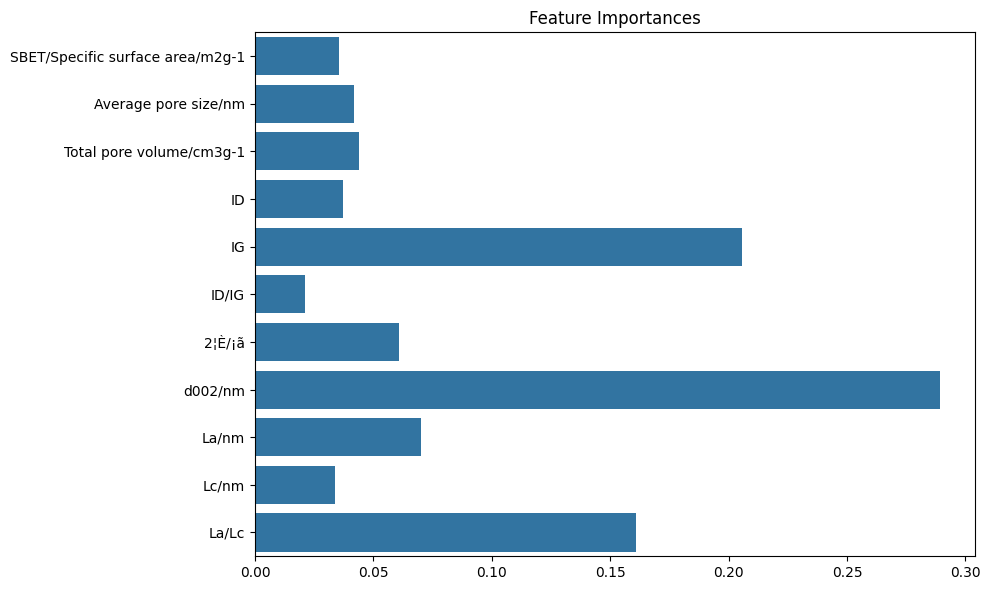

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb
from lightgbm import LGBMRegressor
from scipy.stats import randint, uniform
from matplotlib.backends.backend_pdf import PdfPages
import chardet  # 用于检测文件编码

# 打印 XGBoost 和 LightGBM 版本
print(f"XGBoost version: {xgb.__version__}")

# 1. 加载数据集
dataset_path = r"D:\data\data02.csv"

# 检测文件编码
with open(dataset_path, 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

print(f"Detected encoding: {encoding}")

# 使用检测到的编码读取文件
dataset = pd.read_csv(dataset_path, engine='python', encoding=encoding)

# 2. 数据质量检查：处理异常值或噪声
X = dataset.iloc[:, 0:11]  # 保留 Pandas DataFrame 格式，便于后续分析
y = dataset.iloc[:, 15]

# 检查目标变量的异常值（例如，通过 IQR 方法）
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 移除目标变量的异常值
filtered_dataset = dataset[(y >= lower_bound) & (y <= upper_bound)]
X = filtered_dataset.iloc[:, 0:11]
y = filtered_dataset.iloc[:, 15]

# 3. 特征工程：特征重要性分析
# 使用 XGBoost 的默认参数训练模型，获取特征重要性
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X, y)

# 获取特征重要性
feature_importances = xgb_model.feature_importances_
feature_names = X.columns

# 特征名缩写（确保特殊字符显示正常）
abbreviated_names = {
    "2θ/°": "2Theta",
    "Intensity": "Inten",
    "Peak Width": "PWidth",
    "Peak Height": "PHeight",
    "Background": "Bkg",
    "Lattice Parameter": "LParam",
    "Crystallite Size": "CSize",
    "Strain": "Strain",
    "Phase Composition": "PhaseComp",
    "Surface Area": "SurfArea",
    "Porosity": "Porosity"
}

# 将特征名替换为缩写
abbreviated_feature_names = [abbreviated_names.get(name, name) for name in feature_names]

# 可视化特征重要性
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=abbreviated_feature_names)
plt.title("Feature Importances")
plt.tight_layout()  # 调整布局以确保特征名完整显示

# 4. 数据拆分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. 模型训练和超参数调优
def train_model_with_tuning(model, param_grid, X_train, y_train, cv=5, n_iter=25):
    tuner = RandomizedSearchCV(model, param_grid, n_iter=n_iter, cv=cv, n_jobs=-1, random_state=42, verbose=2)
    tuner.fit(X_train, y_train)
    best_model = tuner.best_estimator_
    print(f"Best parameters: {tuner.best_params_}")
    return best_model

# 调整后的超参数网格
param_grid_lgb = {
    'n_estimators': randint(150, 250),
    'max_depth': randint(5, 15),
    'learning_rate': uniform(0.03, 0.07),
    'subsample': uniform(0.7, 0.2),
    'colsample_bytree': uniform(0.6, 0.3),
    'lambda': randint(100, 200),
    'alpha': uniform(0.5, 1.0),
    'min_child_weight': randint(10, 20)
}

param_grid_xgb = {
    'n_estimators': randint(150, 250),
    'max_depth': randint(5, 15),
    'learning_rate': uniform(0.03, 0.07),
    'subsample': uniform(0.7, 0.2),
    'colsample_bytree': uniform(0.6, 0.3),
    'lambda': randint(100, 200),
    'alpha': uniform(0.5, 1.0),
    'min_child_weight': randint(10, 20)
}

param_grid_rf = {
    'n_estimators': randint(150, 250),
    'max_depth': randint(10, 15),
    'min_samples_split': randint(3, 5),
    'min_samples_leaf': randint(2, 5)
}

# 使用 KFold 代替 RepeatedKFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 训练模型
best_lgb = train_model_with_tuning(LGBMRegressor(random_state=42), param_grid_lgb, X_train, y_train, cv=kf)
best_xgb = train_model_with_tuning(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), param_grid_xgb, X_train, y_train, cv=kf)
best_rf = train_model_with_tuning(RandomForestRegressor(random_state=42), param_grid_rf, X_train, y_train, cv=kf)

# 6. 模型融合：堆叠融合
# 使用交叉验证的预测结果作为堆叠模型的输入
lgb_preds = cross_val_predict(best_lgb, X_train, y_train, cv=kf)
xgb_preds = cross_val_predict(best_xgb, X_train, y_train, cv=kf)
rf_preds = cross_val_predict(best_rf, X_train, y_train, cv=kf)

X_train_stacked = np.column_stack((lgb_preds, xgb_preds, rf_preds))
X_test_stacked = np.column_stack((
    best_lgb.predict(X_test),
    best_xgb.predict(X_test),
    best_rf.predict(X_test)
))

# 使用 Ridge 作为堆叠模型的最终估计器
stacking_model = StackingRegressor(
    estimators=[
        ('lgb', best_lgb),
        ('xgb', best_xgb),
        ('rf', best_rf)
    ],
    final_estimator=Ridge(alpha=1.0)  # 使用带有正则化的线性模型
)

stacking_model.fit(X_train_stacked, y_train)

# 7. 模型评估
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_R2 = r2_score(y_train, y_train_pred)
    test_R2 = r2_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    return train_R2, test_R2, train_mse, test_mse, train_rmse, test_rmse, train_mae, test_mae

# 定义一个函数来绘制预测值与实测值的散点图
def plot_predictions_vs_actual(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, label="Predictions")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--', label="Perfect Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual Values for {model_name}")
    plt.legend()

# 创建 PDF 文件保存所有图片
pdf_path = r"D:\data\Results05.pdf"  # 替换为你想要保存PDF的路径
os.makedirs(os.path.dirname(pdf_path), exist_ok=True)  # 确保目录存在

with PdfPages(pdf_path) as pdf:
    # 保存特征重要性图
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances, y=abbreviated_feature_names)
    plt.title("Feature Importances")
    plt.tight_layout()  # 调整布局以确保特征名完整显示
    pdf.savefig()  # 保存到 PDF
    plt.close()

    # 评估各个模型并保存预测图
    models = {
        'XGBoost': best_xgb,
        'Random Forest': best_rf,
        'LightGBM': best_lgb,
        'Stacking': stacking_model
    }

    results = {}
    for name, model in models.items():
        if name == 'Stacking':
            train_R2, test_R2, train_mse, test_mse, train_rmse, test_rmse, train_mae, test_mae = evaluate_model(model, X_train_stacked, y_train, X_test_stacked, y_test)
            y_pred = model.predict(X_test_stacked)
        else:
            train_R2, test_R2, train_mse, test_mse, train_rmse, test_rmse, train_mae, test_mae = evaluate_model(model, X_train, y_train, X_test, y_test)
            y_pred = model.predict(X_test)

        results[name] = {
            'Train R2': train_R2,
            'Test R2': test_R2,
            'Train MSE': train_mse,
            'Test MSE': test_mse,
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse,
            'Train MAE': train_mae,
            'Test MAE': test_mae
        }

        plot_predictions_vs_actual(y_test, y_pred, name)
        pdf.savefig()  # 保存到 PDF
        plt.close()

    # 输出评估参数
    plt.figure(figsize=(10, 6))
    plt.axis('off')  # 关闭坐标轴
    plt.title("Model Evaluation Metrics")
    table_data = [
        ["Model", "Train R2", "Test R2", "Train MSE", "Test MSE", "Train RMSE", "Test RMSE", "Train MAE", "Test MAE"]
    ]
    for name, metrics in results.items():
        table_data.append([
            name,
            f"{metrics['Train R2']:.4f}",
            f"{metrics['Test R2']:.4f}",
            f"{metrics['Train MSE']:.4f}",
            f"{metrics['Test MSE']:.4f}",
            f"{metrics['Train RMSE']:.4f}",
            f"{metrics['Test RMSE']:.4f}",
            f"{metrics['Train MAE']:.4f}",
            f"{metrics['Test MAE']:.4f}"
        ])
    table = plt.table(cellText=table_data, loc='center', cellLoc='center', colLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    pdf.savefig()  # 保存到 PDF
    plt.close()

print(f"All plots and evaluation metrics have been saved to {pdf_path}")

In [2]:
# 导入必要的库
from scipy.stats import t
import numpy as np

# 定义一个函数来计算置信区间
def calculate_confidence_interval(y_pred, confidence_level=0.95):
    n = len(y_pred)
    mean = np.mean(y_pred)
    std_err = np.std(y_pred, ddof=1) / np.sqrt(n)
    t_value = t.ppf((1 + confidence_level) / 2, n - 1)
    margin_of_error = t_value * std_err
    return mean - margin_of_error, mean + margin_of_error

# 定义一个函数来计算多次运行方差
def calculate_variance_across_runs(model, X, y, n_runs=30):
    predictions = []
    for i in range(n_runs):
        # 使用不同的随机种子
        if hasattr(model, 'random_state'):
            model.set_params(random_state=i)
        model.fit(X, y)
        y_pred = model.predict(X)
        predictions.append(y_pred)
    predictions = np.array(predictions)
    variances = np.var(predictions, axis=0)
    return np.mean(variances)

# 计算并保存置信区间和多次运行方差
results_with_uncertainty = {}
models = {
    'XGBoost': best_xgb,
    'Random Forest': best_rf,
    'LightGBM': best_lgb
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    # 计算置信区间
    ci_lower, ci_upper = calculate_confidence_interval(y_pred)
    
    # 计算多次运行方差
    variance = calculate_variance_across_runs(model, X_train, y_train)
    
    results_with_uncertainty[name] = {
        'Confidence Interval (95%)': (ci_lower, ci_upper),
        'Variance Across Runs': variance
    }

    # 打印结果
    print(f"Model: {name}")
    print(f"Confidence Interval (95%): ({ci_lower:.4f}, {ci_upper:.4f})")
    print(f"Variance Across Runs: {variance:.4f}\n")

# 将置信区间和方差结果保存到 PDF
pdf_path = r"D:\data\Results05.pdf"

with PdfPages(pdf_path) as pdf:
    plt.figure(figsize=(10, 6))
    plt.axis('off')
    plt.title("Model Uncertainty Quantification")
    table_data = [
        ["Model", "Confidence Interval (95%)", "Variance Across Runs"]
    ]
    for name, metrics in results_with_uncertainty.items():
        table_data.append([
            name,
            f"({metrics['Confidence Interval (95%)'][0]:.4f}, {metrics['Confidence Interval (95%)'][1]:.4f})",
            f"{metrics['Variance Across Runs']:.4f}"
        ])
    table = plt.table(cellText=table_data, loc='center', cellLoc='center', colLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    pdf.savefig()
    plt.close()

print("Confidence interval and variance results have been added to the PDF.")

Model: XGBoost
Confidence Interval (95%): (474.8303, 572.6749)
Variance Across Runs: 51.4615

Model: Random Forest
Confidence Interval (95%): (483.3853, 589.3226)
Variance Across Runs: 90.7874

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 287, number of used features: 9
[LightGBM] [Info] Start training from score 512.062146
[LightGBM] [Warning]

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101


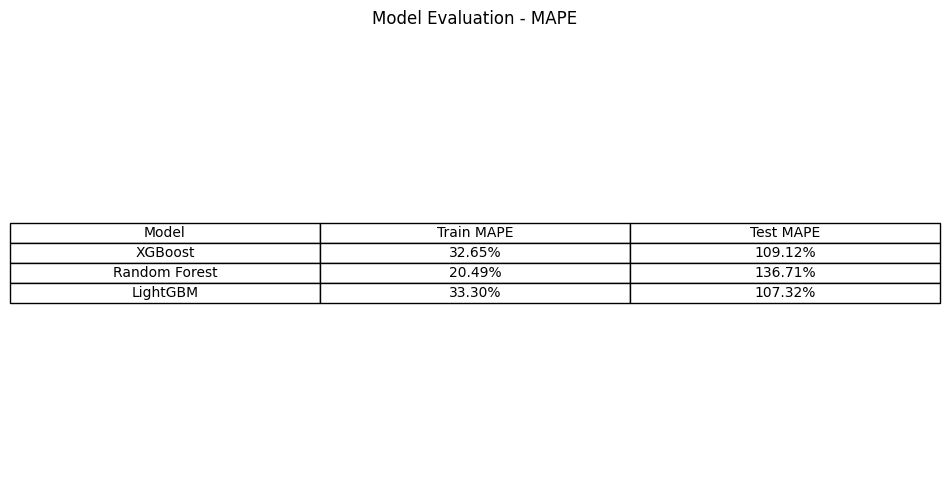

In [3]:
from sklearn.metrics import mean_absolute_error

# 更新evaluate_model函数，只返回MAPE
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 计算MAPE
    def mape(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        # 避免除以零
        mask = y_true != 0
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    train_mape = mape(y_train, y_train_pred)
    test_mape = mape(y_test, y_test_pred)
    
    return train_mape, test_mape

# 在评估模型时，只存储MAPE结果
results = {}
for name, model in models.items():
    if name == 'Stacking':
        train_mape, test_mape = evaluate_model(model, X_train_stacked, y_train, X_test_stacked, y_test)
    else:
        train_mape, test_mape = evaluate_model(model, X_train, y_train, X_test, y_test)

    results[name] = {
        'Train MAPE': train_mape,
        'Test MAPE': test_mape
    }

# 在表格中只显示MAPE
table_data = [
    ["Model", "Train MAPE", "Test MAPE"]
]
for name, metrics in results.items():
    table_data.append([
        name,
        f"{metrics['Train MAPE']:.2f}%",
        f"{metrics['Test MAPE']:.2f}%"
    ])

# 绘制表格并保存到PDF
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.title("Model Evaluation - MAPE")
table = plt.table(cellText=table_data, loc='center', cellLoc='center', colLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=101. Current value: lambda_l2=101


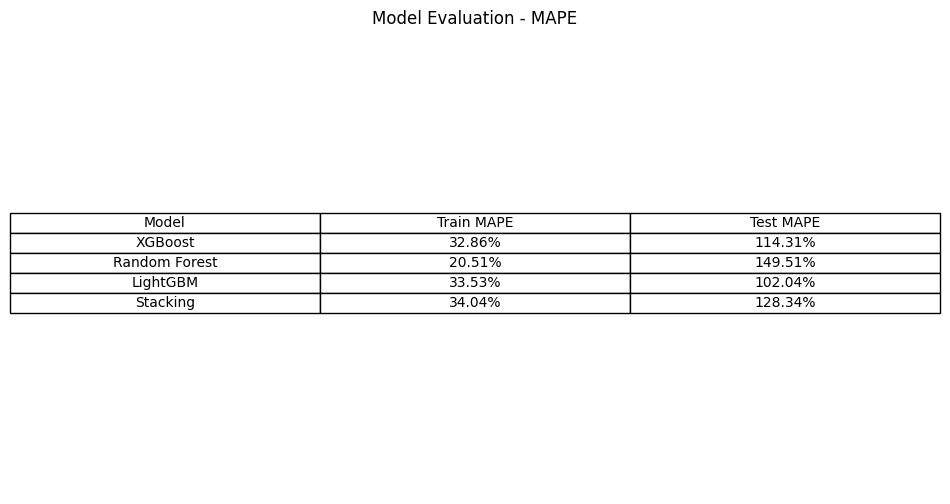

In [2]:
from sklearn.metrics import mean_absolute_error

# 更新evaluate_model函数，只返回MAPE
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 计算MAPE
    def mape(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        # 避免除以零
        mask = y_true != 0
        # 避免除以接近零的值
        epsilon = 1e-8
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + epsilon))) * 100
    
    train_mape = mape(y_train, y_train_pred)
    test_mape = mape(y_test, y_test_pred)
    
    return train_mape, test_mape

# 在评估模型时，只存储MAPE结果
results = {}
for name, model in models.items():
    if name == 'Stacking':
        train_mape, test_mape = evaluate_model(model, X_train_stacked, y_train, X_test_stacked, y_test)
    else:
        train_mape, test_mape = evaluate_model(model, X_train, y_train, X_test, y_test)

    results[name] = {
        'Train MAPE': train_mape,
        'Test MAPE': test_mape
    }

# 在表格中只显示MAPE
table_data = [
    ["Model", "Train MAPE", "Test MAPE"]
]
for name, metrics in results.items():
    table_data.append([
        name,
        f"{metrics['Train MAPE']:.2f}%",
        f"{metrics['Test MAPE']:.2f}%"
    ])

# 绘制表格并保存到PDF
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.title("Model Evaluation - MAPE")
table = plt.table(cellText=table_data, loc='center', cellLoc='center', colLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import chardet  # 用于检测文件编码

# 1. 加载数据集
dataset_path = r"D:\data\data02.csv"

# 检测文件编码
with open(dataset_path, 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

print(f"Detected encoding: {encoding}")

# 使用检测到的编码读取文件
try:
    dataset = pd.read_csv(dataset_path, engine='python', encoding=encoding)
except UnicodeDecodeError as e:
    print(f"Failed to read file with detected encoding {encoding}. Trying other encodings...")
    # 尝试其他常见编码
    for encoding in ['utf-8', 'latin1', 'ISO-8859-1', 'cp1252']:
        try:
            dataset = pd.read_csv(dataset_path, engine='python', encoding=encoding)
            print(f"Successfully read file with encoding {encoding}")
            break
        except UnicodeDecodeError:
            continue
    else:
        raise ValueError("Failed to read file with any known encoding. Please check the file encoding.")

# 2. 数据预处理
X = dataset.iloc[:, 0:11]
y = dataset.iloc[:, 15]

# 特征缩放
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. 数据拆分
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. 模型选择与调优
models = {
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror'),
    'LightGBM': LGBMRegressor()
}

param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }
}

best_models = {}
for name, model in models.items():
    print(f"Tuning {name}...")
    tuner = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=2)
    tuner.fit(X_train, y_train)
    best_models[name] = tuner.best_estimator_
    print(f"Best parameters for {name}: {tuner.best_params_}")

# 5. 模型集成
stacking_model = StackingRegressor(
    estimators=[
        ('rf', best_models['RandomForest']),
        ('gb', best_models['GradientBoosting']),
        ('xgb', best_models['XGBoost']),
        ('lgb', best_models['LightGBM'])
    ],
    final_estimator=Ridge()
)
stacking_model.fit(X_train, y_train)

# 6. 模型评估
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    return train_mape, test_mape

results = {}
for name, model in best_models.items():
    train_mape, test_mape = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = {
        'Train MAPE': train_mape,
        'Test MAPE': test_mape
    }

train_mape, test_mape = evaluate_model(stacking_model, X_train, y_train, X_test, y_test)
results['Stacking'] = {
    'Train MAPE': train_mape,
    'Test MAPE': test_mape
}

# 7. 结果展示
table_data = [
    ["Model", "Train MAPE", "Test MAPE"]
]
for name, metrics in results.items():
    table_data.append([
        name,
        f"{metrics['Train MAPE']:.2f}%",
        f"{metrics['Test MAPE']:.2f}%"
    ])

plt.figure(figsize=(10, 6))
plt.axis('off')
plt.title("Model Evaluation - MAPE")
table = plt.table(cellText=table_data, loc='center', cellLoc='center', colLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.savefig(r"D:\data\MAPE_Results.pdf", bbox_inches='tight')
plt.close()

print("MAPE results have been saved to MAPE_Results.pdf")

Detected encoding: ISO-8859-1
Tuning RandomForest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for RandomForest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Tuning GradientBoosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Tuning XGBoost...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}
Tuning LightGBM...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 295, number of used features: 9
[LightGBM] [Info] S

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import chardet  # 用于检测文件编码

# 1. 加载数据集
dataset_path = r"D:\data\data02.csv"

# 检测文件编码
with open(dataset_path, 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

print(f"Detected encoding: {encoding}")

# 使用检测到的编码读取文件
try:
    dataset = pd.read_csv(dataset_path, engine='python', encoding=encoding)
except UnicodeDecodeError as e:
    print(f"Failed to read file with detected encoding {encoding}. Trying other encodings...")
    # 尝试其他常见编码
    for encoding in ['utf-8', 'latin1', 'ISO-8859-1', 'cp1252']:
        try:
            dataset = pd.read_csv(dataset_path, engine='python', encoding=encoding)
            print(f"Successfully read file with encoding {encoding}")
            break
        except UnicodeDecodeError:
            continue
    else:
        raise ValueError("Failed to read file with any known encoding. Please check the file encoding.")

# 2. 数据预处理
X = dataset.iloc[:, 0:11]
y = dataset.iloc[:, 15]

# 特征缩放
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. 数据拆分
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. 模型选择与调优
models = {
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror'),
    'LightGBM': LGBMRegressor(),
    'CatBoost': CatBoostRegressor(verbose=0)
}

param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    },
    'CatBoost': {
        'iterations': [100, 200, 300],
        'depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'l2_leaf_reg': [1, 3, 5]
    }
}

best_models = {}
for name, model in models.items():
    print(f"Tuning {name}...")
    tuner = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=2)
    tuner.fit(X_train, y_train)
    best_models[name] = tuner.best_estimator_
    print(f"Best parameters for {name}: {tuner.best_params_}")

# 5. 模型集成
stacking_model = StackingRegressor(
    estimators=[
        ('rf', best_models['RandomForest']),
        ('gb', best_models['GradientBoosting']),
        ('xgb', best_models['XGBoost']),
        ('lgb', best_models['LightGBM']),
        ('cat', best_models['CatBoost'])
    ],
    final_estimator=Ridge()
)
stacking_model.fit(X_train, y_train)

# 6. 模型评估
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    return train_mape, test_mape

results = {}
for name, model in best_models.items():
    train_mape, test_mape = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = {
        'Train MAPE': train_mape,
        'Test MAPE': test_mape
    }

train_mape, test_mape = evaluate_model(stacking_model, X_train, y_train, X_test, y_test)
results['Stacking'] = {
    'Train MAPE': train_mape,
    'Test MAPE': test_mape
}

# 7. 结果展示
table_data = [
    ["Model", "Train MAPE", "Test MAPE"]
]
for name, metrics in results.items():
    table_data.append([
        name,
        f"{metrics['Train MAPE']:.2f}%",
        f"{metrics['Test MAPE']:.2f}%"
    ])

plt.figure(figsize=(10, 6))
plt.axis('off')
plt.title("Model Evaluation - MAPE")
table = plt.table(cellText=table_data, loc='center', cellLoc='center', colLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.savefig(r"D:\data\MAPE_Results.pdf", bbox_inches='tight')
plt.close()

print("MAPE results have been saved to MAPE_Results.pdf")

Detected encoding: ISO-8859-1
Tuning RandomForest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for RandomForest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Tuning GradientBoosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Tuning XGBoost...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}
Tuning LightGBM...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 295, number of used features: 9
[LightGBM] [Info] S

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import chardet  # 用于检测文件编码

# 1. 加载数据集
dataset_path = r"D:\data\data02.csv"

# 检测文件编码
with open(dataset_path, 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

print(f"Detected encoding: {encoding}")

# 使用检测到的编码读取文件
try:
    dataset = pd.read_csv(dataset_path, engine='python', encoding=encoding)
except UnicodeDecodeError as e:
    print(f"Failed to read file with detected encoding {encoding}. Trying other encodings...")
    # 尝试其他常见编码
    for encoding in ['utf-8', 'latin1', 'ISO-8859-1', 'cp1252']:
        try:
            dataset = pd.read_csv(dataset_path, engine='python', encoding=encoding)
            print(f"Successfully read file with encoding {encoding}")
            break
        except UnicodeDecodeError:
            continue
    else:
        raise ValueError("Failed to read file with any known encoding. Please check the file encoding.")

# 2. 数据预处理
X = dataset.iloc[:, 0:11]
y = dataset.iloc[:, 15]

# 特征缩放
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 特征选择
rfecv = RFECV(estimator=RandomForestRegressor(), step=1, cv=5, scoring='neg_mean_absolute_percentage_error')
X_selected = rfecv.fit_transform(X_scaled, y)

# 数据平滑
y_smoothed = y.rolling(window=5, center=True).mean().fillna(y)

# 3. 数据拆分
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_smoothed, test_size=0.2, random_state=42)

# 4. 模型选择与调优
models = {
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror'),
    'LightGBM': LGBMRegressor(),
    'CatBoost': CatBoostRegressor(verbose=0)
}

param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    },
    'CatBoost': {
        'iterations': [100, 200, 300],
        'depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'l2_leaf_reg': [1, 3, 5]
    }
}

best_models = {}
for name, model in models.items():
    print(f"Tuning {name}...")
    tuner = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=2)
    tuner.fit(X_train, y_train)
    best_models[name] = tuner.best_estimator_
    print(f"Best parameters for {name}: {tuner.best_params_}")

# 5. 模型集成
stacking_model = StackingRegressor(
    estimators=[
        ('rf', best_models['RandomForest']),
        ('gb', best_models['GradientBoosting']),
        ('xgb', best_models['XGBoost']),
        ('lgb', best_models['LightGBM']),
        ('cat', best_models['CatBoost'])
    ],
    final_estimator=Ridge()
)
stacking_model.fit(X_train, y_train)

# 6. 模型评估
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    return train_mape, test_mape

results = {}
for name, model in best_models.items():
    train_mape, test_mape = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = {
        'Train MAPE': train_mape,
        'Test MAPE': test_mape
    }

train_mape, test_mape = evaluate_model(stacking_model, X_train, y_train, X_test, y_test)
results['Stacking'] = {
    'Train MAPE': train_mape,
    'Test MAPE': test_mape
}

# 7. 结果展示
table_data = [
    ["Model", "Train MAPE", "Test MAPE"]
]
for name, metrics in results.items():
    table_data.append([
        name,
        f"{metrics['Train MAPE']:.2f}%",
        f"{metrics['Test MAPE']:.2f}%"
    ])

plt.figure(figsize=(10, 6))
plt.axis('off')
plt.title("Model Evaluation - MAPE")
table = plt.table(cellText=table_data, loc='center', cellLoc='center', colLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.savefig(r"D:\data\MAPE_Results.pdf", bbox_inches='tight')
plt.close()

print("MAPE results have been saved to MAPE_Results.pdf")

Detected encoding: ISO-8859-1
Tuning RandomForest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Tuning GradientBoosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for GradientBoosting: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Tuning XGBoost...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters for XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}
Tuning LightGBM...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 295, number of used features: 9
[LightGBM] [Info]